# SMM with Gradient Descent

## Python Imports

In [27]:
import numpy as np
import random
import copy
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from itertools import combinations
import csv

## Data Imports

## DEFINE THE PATH TO YOUR COURSE DIRECTORY

In [2]:
data_dir = "data/"

### Hannah's partition scheme and loading

In [3]:
def load_blosum(filename):
    """
    Read in BLOSUM values into matrix.
    """
    aa = ['A', 'R', 'N' ,'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X']
    df = pd.read_csv(filename, sep=' ', comment='#', index_col=0)
    return df.loc[aa, aa]

def load_peptide_target(filename, MAX_PEP_SEQ_LEN=9):
    """
    Read amino acid sequence of peptides and
    corresponding log transformed IC50 binding values from text file.
    """
    df = pd.read_csv(filename, sep=' ', usecols=[0,1], names=['peptide','target'])
    return df[df.peptide.apply(len) <= MAX_PEP_SEQ_LEN]

def load_pickle(f):
    with open(f, 'rb') as source:
        s = pickle.load(source)
    return s

def load_partitions(files):
    o = []
    for f in files:
        data = load_pickle(f)
        o += data
    return o

def assign_cv_partition(partition_files, n_folds=5, n_test=1):
    """Figure out all combinations of partition_files to assign as train and test data in CV"""

    # how many combinations of partition_files in train part
    n_train = n_folds - n_test

    # find all combinations of the partition_files with n_train files in each
    train_files = list(combinations(partition_files, n_train))

    # convert each list element to tuple so (train_partitions, test_partition)
    files = [
        (x, list(set(partition_files) - set(x))) for x in train_files
    ]

    return files

def data_partition(partition_files, data, blosum_file, batch_size=32, n_features=9):
    partitions = load_partitions(partition_files)

    selected_data = data.loc[data.peptide.isin(partitions), ].reset_index()

    X, y = encode_peptides(selected_data, blosum_file=blosum_file, batch_size=batch_size, n_features=n_features)

    # reshape X
    X = X.reshape(X.shape[0], -1)

    return X, y

def encode_peptides(Xin, blosum_file, batch_size, n_features, MAX_PEP_SEQ_LEN=9):
    """
    Encode AA seq of peptides using BLOSUM50.
    Returns a tensor of encoded peptides of shape (batch_size, MAX_PEP_SEQ_LEN, n_features)
    """
    blosum = load_blosum(blosum_file)
    
    batch_size = len(Xin)
    n_features = len(blosum)
    
    Xout = np.zeros((batch_size, MAX_PEP_SEQ_LEN, n_features), dtype=np.int8) # should it be uint? is there a purpose to that?
    
    for peptide_index, row in Xin.iterrows():
        for aa_index in range(len(row.peptide)):
            Xout[peptide_index, aa_index] = blosum[ row.peptide[aa_index] ].values
            
    return Xout, Xin.target.values


data = load_peptide_target('data/A0201/A0201.dat')

encoding_file = 'data/BLOSUM50' # could change it to data/sparse

training_files = ['data/partition_3.txt', 'data/partition_2.txt', 'data/partition_6.txt', 'data/partition_5.txt', 'data/partition_4.txt']
testing_files = ['data/test_partitions.pkl']

training_partitions = load_partitions(training_files)
testing_partitions = load_partitions(testing_files)

data = pd.read_csv('data/A0201/A0201.dat', sep=' ', header=None, names=['peptide', 'target'], usecols=[0, 1])

training_selected = data.loc[data.peptide.isin(training_partitions),].reset_index()
testing_selected = data.loc[data.peptide.isin(testing_partitions),].reset_index()

outer_peptides, outer_y=encode_peptides(training_selected, encoding_file,32,9)
validation_peptides, validation_targets=encode_peptides(testing_selected, encoding_file,32,9)

outer_peptides = outer_peptides.reshape(outer_peptides.shape[0], -1)
validation_peptides=validation_peptides.reshape(validation_peptides.shape[0], -1)


### Alphabet

In [4]:
alphabet_file = data_dir + "Matrices/alphabet"
alphabet = np.loadtxt(alphabet_file, dtype=str)

## Error Function

In [5]:
def cumulative_error(peptides, y, lamb, weights):

    error = 0
    
    for i in range(0, len(peptides)):
        
        # get peptide
        peptide = peptides[i]

        # get target prediction value
        y_target = y[i]
        
        # get prediction
        y_pred = np.dot(peptide, weights)
            
        # calculate error
        error += 1.0/2 * (y_pred - y_target)**2
        
    gerror = error + lamb*np.dot(weights, weights)
    error /= len(peptides)
        
    return gerror, error

## Predict value for a peptide list

In [6]:
def predict(peptides, weights):

    pred = []
    
    for i in range(0, len(peptides)):
        
        # get peptide
        peptide = peptides[i]
        
        # get prediction
        y_pred = np.dot(peptide, weights)
        
        pred.append(y_pred)
        
    return pred


## Calculate MSE between two vectors

In [7]:
def cal_mse(vec1, vec2):
    
    mse = 0
    
    for i in range(0, len(vec1)):
        mse += (vec1[i] - vec2[i])**2
        
    mse /= len(vec1)
    
    return( mse)

## Gradient Descent

In [8]:
def gradient_descent(y_pred, y_target, peptide, weights, lamb_N, epsilon):
    
    # do is dE/dO
    #do = XX
    do = y_pred - y_target
    
    for i in range(0, len(weights)):
        
        #de_dw_i = XX
        de_dw_i = do * peptide[i] + 2 * lamb_N * weights[i]
        #weights[i] -= XX
        weights[i] -= epsilon * de_dw_i

### Make storage for inner loop predictions

In [9]:
def make_storage(hyper_parameter_1, hyper_parameter_2):
    store_predictions={}

    for i in hyper_parameter_1:
    
        store_predictions[i]={}
    
        for j in hyper_parameter_2:
        
            store_predictions[i][j] = []
    return(store_predictions)



## Main Loop



In [10]:

storage_pred = make_storage(["a"],["b"])
storage_target = make_storage(["a"],["b"])
chosen_lambda = 1

epochs = 100

#Use Hannahs encoding loading
encoding_file = 'data/BLOSUM50' # could change it to data/sparse

# Random seed 
np.random.seed( 1 )

# early stopping
early_stopping = True



#get outer training set from outer partition for training with optimal parameters
#outer_peptides, outer_y = ### ['data/partition_3.txt', 'data/partition_2.txt', 'data/partition_6.txt', 'data/partition_5.txt', 'data/partition_4.txt']
    
#get validation set from the outer partition to validate model one
#validation_peptides, validation_targets = ### ['data/test_partitions.pkl']



N = len(outer_peptides)
lamb=chosen_lambda
lamb_N = lamb/N
epsilon=5e-05
stopping_error = np.inf # for early stopping
# weights
input_dim  = len(outer_peptides[0])
w_bound = 0.1
weights = np.random.uniform(-w_bound, w_bound, size=input_dim)
            
# for each training epoch
for e in range(0, epochs):
    # for each peptide
    for i in range(0, N):

        # random index
        ix = np.random.randint(0, N)

        # get peptide       
        peptide = outer_peptides[ix]

        # get target prediction value
        y_target = outer_y[ix]
        #print(y_target)
        # get initial prediction
        y_pred = np.dot(peptide, weights)
        #print(y_pred)
        # gradient descent 
        gradient_descent(y_pred, y_target, peptide, weights, lamb_N, epsilon) # updates weights

        

    # predict on outer test (validation data)
    eval_pred = predict(validation_peptides, weights )
    eval_mse = cal_mse(validation_targets, eval_pred )
    #eval_pcc = pearsonr(validation_targets, eval_pred) don't calculate it unless needed

    # early stopping
    if early_stopping:

        if eval_mse < stopping_error:

            stopping_error = eval_mse # save to compare future loops
            stopping_pcc = pearsonr(validation_targets, eval_pred)[0]
            stopping_pred = eval_pred[:]
storage_pred["a"]["b"].extend(stopping_pred)
storage_target["a"]["b"].extend(validation_targets)
print("Lambda: ", lamb,"Epsilon: ", epsilon, "PCC: ", stopping_pcc)



Lambda:  1 Epsilon:  5e-05 PCC:  0.7147949281613302


### Input Marius' code

<class 'list'>


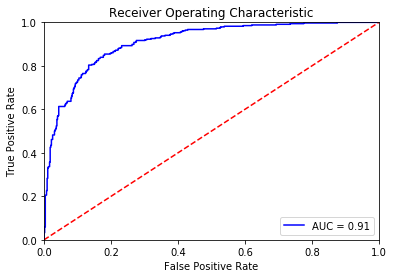

Preds and targets not normally distributed (according to shapiro) -> only do Spearman
SCC SpearmanrResult(correlation=0.7374365613970824, pvalue=1.7502553951305114e-152)


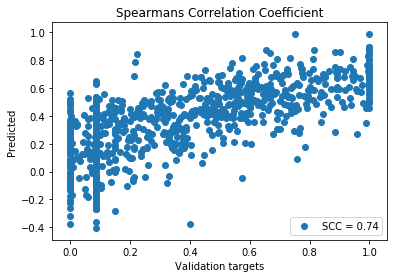

In [13]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

import seaborn as sns

from scipy import stats

# BINDER_THRESHOLD (from Helle - I guess we use this, but not sure what the best argumentation would be)
BINDER_THRESHOLD = 0.426

#fill out
x_test =np.asarray(storage_pred["a"]["b"])
y_test =np.asarray(storage_target["a"]["b"])
pred =np.asarray(storage_pred["a"]["b"])
print(type(storage_pred["a"]["b"]))
targets = np.asarray(storage_target["a"]["b"])

### ROC/AUC
## net.eval depending on method - here ANN
#net.eval()
#pred = net(x_test)
#loss = criterion(pred, y_test)

#plot_target_values(data=[(pd.DataFrame(pred.data.numpy(), columns=['target']), 'Prediction'),
#                         (test_raw, 'Target')])

y_test_class = np.where(y_test.flatten() >= BINDER_THRESHOLD, 1, 0)
y_pred_class = np.where(pred.flatten() >= BINDER_THRESHOLD, 1, 0)
#y_test_class = np.where(y_test >= BINDER_THRESHOLD, 1, 0)
#y_pred_class = np.where(pred >= BINDER_THRESHOLD, 1, 0)

#fpr, tpr, threshold = roc_curve(y_test_class, pred.flatten().detach().numpy())
fpr, tpr, threshold = roc_curve(y_test_class, pred.flatten())

roc_auc = auc(fpr, tpr)



def plot_roc_curve():
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_roc_curve()


### SCC and PCC

scc = stats.spearmanr(pred, targets)
def plot_scc():
    plt.title('Spearmans Correlation Coefficient')
    #plt.scatter(y_test.flatten().detach().numpy(), pred.flatten().detach().numpy(), label = 'SCC = %0.2f' % scc)
    plt.scatter(y_test, pred, label = 'SCC = %0.2f' % scc[0])
    plt.legend(loc = 'lower right')
    plt.ylabel('Predicted')
    plt.xlabel('Validation targets')
    plt.show()


pcc = stats.pearsonr(pred, targets)
def plot_pcc():
    plt.title('Pearsons Correlation Coefficient')
    #plt.scatter(y_test.flatten().detach().numpy(), pred.flatten().detach().numpy(), label = 'PCC = %0.2f' % pcc)
    plt.scatter(y_test, pred, label = 'PCC = %0.2f' % pcc[0])
    plt.legend(loc = 'lower right')
    plt.ylabel('Predicted')
    plt.xlabel('Validation targets')
    plt.show()


### Spearman
if stats.shapiro(pred)[1] > 0.05 and stats.shapiro(targets)[1] > 0.05:
    print('Preds and targets normally distributed (according to shapiro)')
    print('PCC', stats.pearsonr(pred, targets))
    plot_pcc()
    print('SCC', stats.spearmanr(pred, targets))
    plot_scc()
else:
    print('Preds and targets not normally distributed (according to shapiro) -> only do Spearman')
    print('SCC', stats.spearmanr(pred, targets))
    plot_scc()

### Code for Hannah to make comparative plots

In [61]:
# Best weights from outer loop

Hannah_weights=[0.0294279,-0.01799774,0.00881117,-0.01061445,-0.00362678,0.00278902,-0.0142268,-0.00516224,0.02140116,0.06757149,-0.06734245,0.00994926,0.03051233,-0.0545,0.0255861,0.05255853,0.01935181,-0.00742817,-0.06216534,0.02726204,0.06008355,0.03498114,-0.03196142,0.02021266,0.03131575,-0.01613499,-0.03232758,-0.03113148,-0.03519959,-0.00765824,0.00876278,-0.02954185,0.00613928,-0.0229228,0.00701509,-0.01033367,0.0084963,-0.00454838,-0.01192415,-0.00052661,-0.01226085,0.02111508,-0.01561105,-0.01216794,-0.06983957,0.01410866,-0.00814402,0.07042516,0.0307609,-0.0038495,0.04544555,0.03225133,-0.02371291,-0.00449118,-0.0238077,-0.05162127,0.02517059,0.08233519,-0.01448752,0.00277984,0.02774853,0.00059775,0.03373287,-0.00528239,-0.00243205,-0.0099172,-0.01420157,-0.00637491,-0.01340493,-0.02137411,0.01306964,0.01346978,0.00628878,-0.02970415,-0.0055546,-0.01613896,0.0003441,-0.00462879,-0.02921856,-0.02375896,-0.00366497,0.02052536,-0.01284542,-0.00277019,-0.04645067,0.01430928,0.11040722,0.00929266,-0.01106119,-0.10069887,-0.01765468,0.02379294,-0.00337456,-0.00847296,-0.02772761,-0.06109968,-0.00525104,-0.01291084,-0.0187987,-0.01290103,0.06142094,-0.0050189,0.06392011,-0.01300322,-0.00619793,0.00389364,-0.01381762,-0.02153875,-0.02185224,-0.00803255,0.00030812,-0.02046788,0.02449066,0.02790529,0.00489986,-0.01268361,0.00385041,-0.0266745,-0.06273933,0.0154493,0.03759752,-0.0163005,0.0006202,0.0163516,0.01313384,0.01312801,-0.00872655,-0.00326819,-0.04584115,-0.00515692,-0.0009834,0.03050439,-0.0167052,0.00621953,-0.00833903,-0.01296962,0.01091865,0.03402522,-0.01583335,-0.00014861,0.00893016,0.01763936,-0.0275079,0.01775032,-0.02412762,0.01050522,0.01305708,-0.04509626,0.02460351,-0.02825578,0.00985626,0.0032692,0.01556903,0.00051019,0.02480562,-0.01445783,-0.05763981,0.06135121,-0.00869194,-0.01288933,0.00884672,0.00564513,0.02136976,-0.02085559,0.00813219,0.02904764,0.01137837,-0.05861588,-0.00292961,-0.02056224,-0.02913724,0.07457515,-0.01205798,0.05868146,0.07403353,-0.08104796,-0.02152113,0.01207038,-0.01162087,0.00328795,-0.0078607,0.03533587,-0.01819491,0.0239793,-0.0124951,-0.01002155,0.02579918,0.0486488,-0.00414094]

In [77]:
Hannah_files = ['data/test_partitions.pkl','data/partition_3.txt', 'data/partition_2.txt', 'data/partition_6.txt', 'data/partition_5.txt', 'data/partition_4.txt']

Hannah_partitions = load_partitions(Hannah_files)

data = pd.read_csv('data/A0201/A0201.dat', sep=' ', header=None, names=['peptide', 'target'], usecols=[0, 1])

Hannah_selected = data.loc[data.peptide.isin(Hannah_partitions),].reset_index()
Hannah_peptide_names = pd.read_csv('data/A0201/A0201.dat', sep=' ', header=None, names=['peptide', 'target'], usecols=[0, 1])

Hannah_peptides, Hannah_y=encode_peptides(Hannah_selected, encoding_file,32,9)

Hannah_peptides = Hannah_peptides.reshape(Hannah_peptides.shape[0], -1)
len(Hannah_peptides)

Hannah_eval_pred = predict(Hannah_peptides, Hannah_weights )

print(len(Hannah_eval_pred))
print(len(Hannah_partitions))
print(len(Hannah_y))

3089
3089
3089


In [83]:
csv_table=[Hannah_selected['peptide'],Hannah_y,Hannah_eval_pred]

In [84]:
#np.savetxt("smm_target_prediction_all_targets.txt", np.array(csv_table).T, delimiter=",",fmt='%s')


In [91]:
#sum(Hannah_y == Hannah_selected['target'])

3089

In [88]:
 #Hannah_selected['peptide']

0       AAAATCALV
1       AAAKTPVIV
2       AAEQRRSTI
3       ACMDGFEVV
4       ADLRFASEF
          ...    
3084    YVGDTSMMV
3085    YVHGDTYSL
3086    YVIGLLPQS
3087    YVLLHLLVV
3088    YYYNFSEDL
Name: peptide, Length: 3089, dtype: object

In [93]:
 pred.flatten()

array([ 6.49276473e-01,  6.34817040e-02,  9.74889023e-02,  7.03893875e-02,
        6.68913342e-02,  4.61621058e-01,  4.94525384e-01,  5.36711684e-01,
        7.35639166e-01,  5.13347717e-01,  5.58272772e-01,  5.82358055e-01,
        1.31113591e-01,  1.43269743e-01,  2.71633913e-01,  1.36592457e-01,
        4.48381596e-01,  2.65915855e-02,  3.28202586e-01, -2.21851852e-01,
        2.10264607e-01, -3.03189452e-02, -2.62239672e-01,  3.52319020e-01,
        3.13681759e-01,  2.47596933e-01,  4.92079735e-01,  3.25436537e-02,
        5.53024793e-01,  4.13602129e-01,  7.68471604e-01,  5.74999216e-01,
        6.85986409e-01,  6.82824311e-01,  6.79816013e-01,  7.81424214e-01,
        7.29869067e-01,  4.50684998e-01,  6.08671976e-02,  8.81795230e-02,
        5.22202201e-01,  4.97245553e-01,  5.63993918e-01,  2.82629687e-01,
        1.24370825e-01,  5.16159773e-01,  1.27585085e-01,  4.14764837e-01,
        6.99569131e-02,  4.14036337e-01, -1.61210734e-01, -2.61644898e-01,
        1.73243638e-01, -